# RNA - Atividade 2.1 - Perceptron de Rosenblatt

Neste projeto prático, o objetivo é implementar o algoritmo de treinamento mediante Aprendizado Supervisionado do neurônio Perceptron de Rosenblatt aplicado em problemas de classificação. Para tanto, cada equipe deverá elaborar Jupyter Notebooks com o código-fonte deste algoritmo de treinamento desenvolvido na linguagem de Programação Python e fazendo uso das bibliotecas numpy, random, math e matplotlib. Em particular, a biblioteca numpy será de uso obrigatório para todas as operações de natureza matricial (multiplicação de matrizes, produto escalar, etc). Neste projeto prático, a biblioteca sci-kit learn só deve ser utilizada para o cálculo de métricas de desempenho.

## Equipe

- Daniele Simas - 2015310060
- Felipe Amorim - 2115080033
- José Manuel - 2115080052
- Miguel Angelo - 2115080024

## Importação de Bibliotecas

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Parte 1 - Resolvendo um problema linearmente separável

Nesta parte, todas as equipes devem usar o arquivo `dataAll.txt` e construir o algoritmo de treinamento do neurônio perceptron para resolver o problema de classificação proposto.

In [105]:
# Classe para controlar o treinamento do perceptron
from perceptron import Perceptron

# Funções auxiliares para carregar os arquivos do exercicio
from utils import read_data, identifier

# Funções de ativação
import activation_functions

In [106]:
data = read_data('All')

print("Quantidade de pontos lidos: ", len(data))
print("Formato dos dados: ", data.shape)
print("\nExemplos de dados: ", *[(x, y) for x,y in data[:5]], sep='\n')

Quantidade de pontos lidos:  1000
Formato dos dados:  (1000, 2)

Exemplos de dados: 
(array([-363.7884,  244.1423]), 0.0)
(array([ 328.7572, -256.7658]), 1.0)
(array([-164.9827,  613.2164]), 0.0)
(array([536.5905, 764.9575]), 0.0)
(array([314.2297, 343.8375]), 0.0)


1. As equipes devem utilizar a função de ativação degrau com ϑ = 0;
2. O valor da taxa de aprendizado deve ser igual a η = 0,1;
3. O vetor inicial de pesos deve ter seus valores inicializados conforme uma variável aleatória de distribuição uniforme no intervalo, isto é, wi ∼ U (−0,5, + 0,5). O vetor inicial de pesos deve ser impresso no início da execução do algoritmo;

In [107]:
perceptron = Perceptron(data=data, activation_function=activation_functions.step_function, bias=-1, learning_rate=0.1)

print('Vetor de pesos inicial: ', perceptron.weights)

perceptron.randomize_weights(floor=-0.5, ceiling=0.501)
print('Vetor de pesos após a randomização: ', perceptron.weights)

Vetor de pesos inicial:  [0. 0. 0.]
Vetor de pesos após a randomização:  [-0.27553833 -0.26522355 -0.11247846]


4. A cada época deve ser indicado o número de ajustes feitos no vetor de pesos;
5. O algoritmo deve executar até a convergência, isto é, até que não haja erros para todos os exemplos presentes no conjunto de treinamento;
6. Ao final, deve-se imprimir:
    - A - O número total de ajustes no vetor de pesos;
    - B - O número de épocas até a convergência;
    - C - O gráfico contendo todos os exemplos do conjunto de dados e a reta que separa as classes obtida como resultado do treinamento do neurônio Perceptron. Respeitar o esquema de cores proposto inicialmente e apresentar a solução de maneira clara neste gráfico.

In [108]:
epoch, updates = perceptron.train()

print('Treinamento finalizado!')
print('Quantidade de épocas até a convergência: ', epoch)
print('Quantidade de ajustes no vetor de pesos: ', updates)

print("Vetor de pesos final: ", perceptron.weights)

Treinamento finalizado!
Quantidade de épocas até a convergência:  2
Quantidade de ajustes no vetor de pesos:  24
Vetor de pesos final:  [  -0.67553833  218.53731645 -217.84472846]


In [117]:

def plot_results(data, final_weights):
    plt.figure(figsize=(8,8))
    
    # Separar as características (x1, x2) e os rótulos
    X = data[:, :-1]
    y = data[:, -1]

    # Criar gráfico de dispersão dos pontos de entrada usando o parametro "data"
    for i in range(len(X)):
        x1 = X[i]
        x2 = X[i]
        label = y[i]
        if label == 1:
            plt.scatter(x1, x2, color='blue', marker='o', label='Class 1' if 'Class 1' not in plt.gca().get_legend_handles_labels()[1] else "")
        else:
            plt.scatter(x1, x2, color='red', marker='x', label='Class 0' if 'Class 0' not in plt.gca().get_legend_handles_labels()[1] else "")
    
    # Criar gráfico de linha da reta x2 = -(w1/w2)x1 + (w0/w2) gerada pelo perceptron
    w0, w1, w2 = final_weights
    x1_values = np.linspace(min(X[:, 0]) - 1, max(X[:, 0]) + 1, 200)
    x2_values = -(w1 / w2) * x1_values - (w0 / w2)
    plt.plot(x1_values, x2_values, color='green', linestyle='-', linewidth=2, label='Decision Boundary')

    # Adicionar títulos e legendas
    plt.title('Decision Boundary and Data Points')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True)
    plt.show()



ValueError: setting an array element with a sequence.

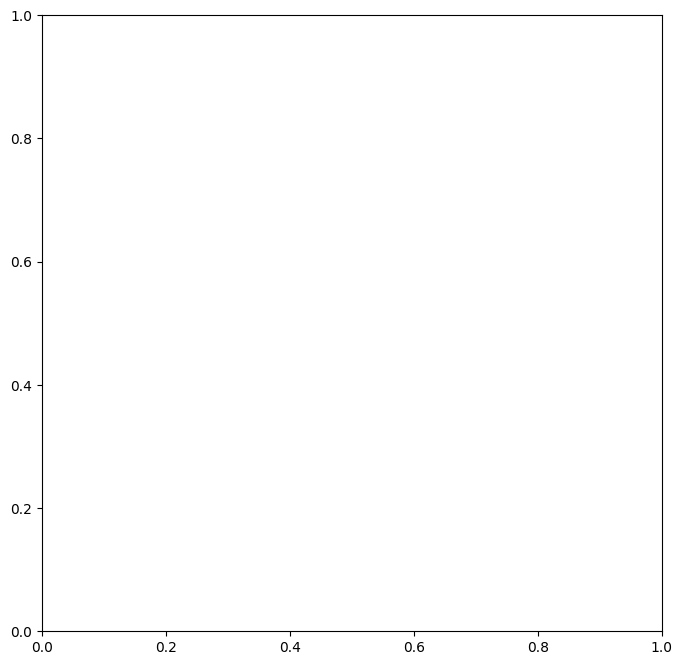

In [118]:
plot_results(data,perceptron.weights)